# Layer Decomposition and Reconstruction with Morphological Closing Operations

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.morphology import binary_dilation, binary_closing, disk
from matplotlib.colors import ListedColormap
import os

Image loaded: 727x456 pixels
Unique values: [0 1 2 3 4]
Number of layers: 5


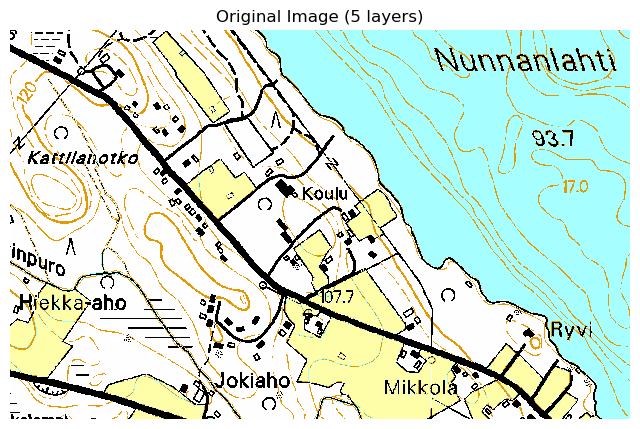

In [2]:
# Load and prepare image
image_path = '../data/map_image.png'
original_image = np.array(Image.open(image_path))

if len(original_image.shape) == 3:
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
else:
    gray_image = original_image

height, width = gray_image.shape
unique_values = np.unique(gray_image)
num_layers = len(unique_values)

print(f"Image loaded: {width}x{height} pixels")
print(f"Unique values: {unique_values}")
print(f"Number of layers: {num_layers}")

# Extract binary layers
def extract_binary_layers(image, num_layers):
    layers = []
    min_val, max_val = image.min(), image.max()
    thresholds = np.linspace(min_val, max_val, num_layers + 1)
    
    for i in range(num_layers):
        lower_thresh = thresholds[i]
        upper_thresh = thresholds[i + 1]
        
        if i == num_layers - 1:
            layer_mask = (image >= lower_thresh) & (image <= upper_thresh)
        else:
            layer_mask = (image >= lower_thresh) & (image < upper_thresh)
        
        layers.append(layer_mask.astype(np.uint8))
    
    return layers

binary_layers = extract_binary_layers(gray_image, num_layers)

# Display original image
custom_colors = ['#000000', '#fefefe', '#e59800', '#a7fefe', '#fffea8']
custom_cmap = ListedColormap(custom_colors)

plt.figure(figsize=(8, 6))
plt.imshow(gray_image, cmap=custom_cmap, vmin=gray_image.min(), vmax=gray_image.max())
plt.title("Original Image (5 layers)")
plt.axis('off')
plt.show()

In [3]:
# Task 1: Remove Contour Layer
contour_removed = np.zeros_like(gray_image, dtype=gray_image.dtype)

for i in range(num_layers):
    if i != 2:  # Skip layer 3 (contours)
        layer_mask = binary_layers[i].astype(bool)
        original_pixel_value = unique_values[i]
        contour_removed[layer_mask] = original_pixel_value

gaps_to_fill_contour = binary_layers[2].astype(bool)
contour_reconstructed = contour_removed.copy()
se = disk(3)

for i in range(num_layers):
    if i != 2: 
        original_layer = binary_layers[i].astype(bool)
        original_pixel_value = unique_values[i]
        
        closed_layer = binary_closing(original_layer, se)
        expanded_areas = np.logical_and(closed_layer, ~original_layer)
        gap_filling_areas = np.logical_and(expanded_areas, gaps_to_fill_contour)
        
        contour_reconstructed[gap_filling_areas] = original_pixel_value
        gaps_to_fill_contour = np.logical_and(gaps_to_fill_contour, ~gap_filling_areas)
        
        filled = np.sum(gap_filling_areas)

In [4]:
# Remove layers roads and contours
double_removed = np.zeros_like(gray_image, dtype=gray_image.dtype)
layers_to_keep = [1, 3, 4]

for i in layers_to_keep:
    layer_mask = binary_layers[i].astype(bool)
    original_pixel_value = unique_values[i]
    double_removed[layer_mask] = original_pixel_value


double_reconstructed = double_removed.copy()
gaps_remaining = (double_reconstructed == 0)

for se_radius in [3, 5, 7, 10]:
    if np.sum(gaps_remaining) == 0:
        break
        
    se_large = disk(se_radius)
    for i in layers_to_keep:
        if np.sum(gaps_remaining) == 0:
            break
            
        original_layer = binary_layers[i].astype(bool)
        original_pixel_value = unique_values[i]
        
        closed_layer = binary_closing(original_layer, se_large)
        expanded_areas = np.logical_and(closed_layer, ~original_layer)
        gap_filling_areas = np.logical_and(expanded_areas, gaps_remaining)
        
        double_reconstructed[gap_filling_areas] = original_pixel_value
        gaps_remaining = np.logical_and(gaps_remaining, ~gap_filling_areas)

if np.sum(gaps_remaining) > 0:
    gap_positions = np.where(gaps_remaining)
    for gap_y, gap_x in zip(gap_positions[0], gap_positions[1]):
        neighbor_values = []
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                ny, nx = gap_y + dy, gap_x + dx
                if 0 <= ny < height and 0 <= nx < width:
                    if double_reconstructed[ny, nx] != 0:
                        neighbor_values.append(double_reconstructed[ny, nx])
        
        if neighbor_values:
            unique_vals, counts = np.unique(neighbor_values, return_counts=True)
            most_common_value = unique_vals[np.argmax(counts)]
            double_reconstructed[gap_y, gap_x] = most_common_value
        else:
            for dy in range(-2, 3):
                for dx in range(-2, 3):
                    ny, nx = gap_y + dy, gap_x + dx
                    if 0 <= ny < height and 0 <= nx < width:
                        if double_reconstructed[ny, nx] != 0:
                            neighbor_values.append(double_reconstructed[ny, nx])
            
            if neighbor_values:
                unique_vals, counts = np.unique(neighbor_values, return_counts=True)
                most_common_value = unique_vals[np.argmax(counts)]
                double_reconstructed[gap_y, gap_x] = most_common_value
            else:
                double_reconstructed[gap_y, gap_x] = unique_values[layers_to_keep[0]]

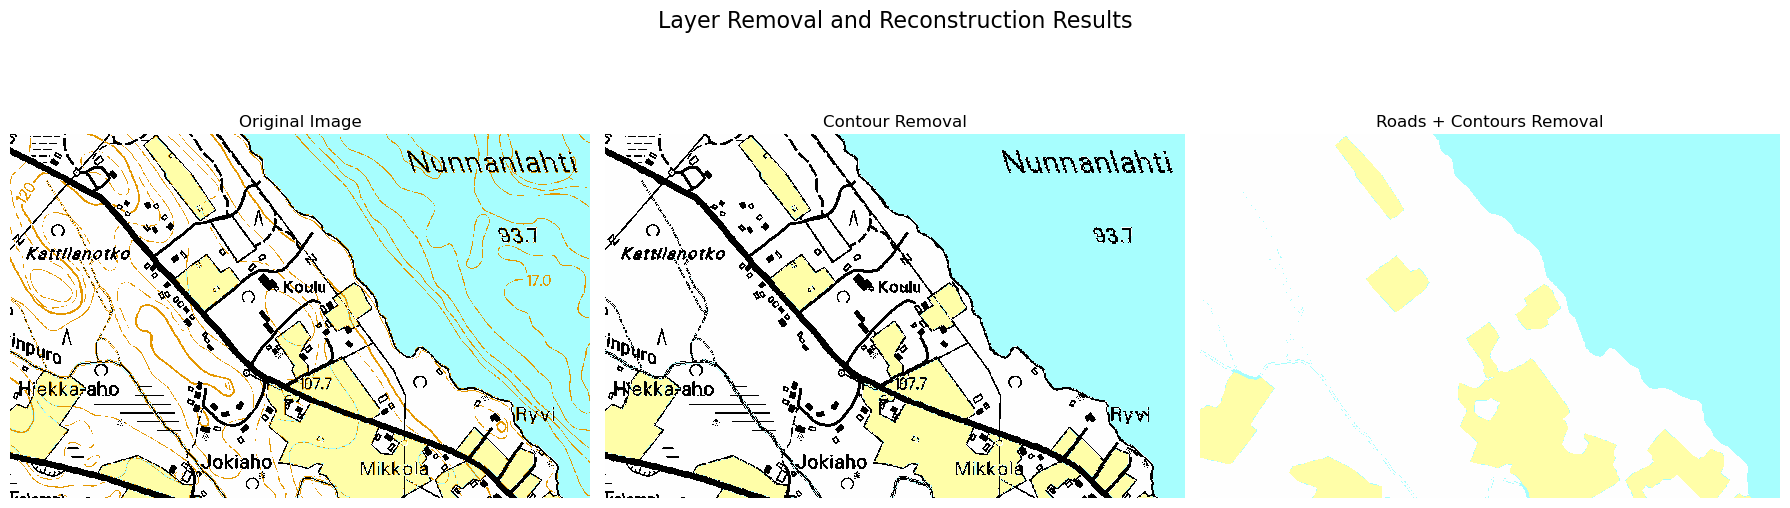

In [5]:
# Final Results Visualization
# Create colormaps
contour_colors = ['#000000', '#fefefe', '#000000', '#a7fefe', '#fffea8']
contour_cmap = ListedColormap(contour_colors)

# Create optimized colormap for exactly 3 layers [1,3,4]
optimized_colors = ['#fefefe', '#a7fefe', '#fffea8']  # White, Blue, Yellow
remapped_result = np.zeros_like(double_reconstructed)
color_mapping = {1: 0, 3: 1, 4: 2}

for original_val, new_val in color_mapping.items():
    mask = double_reconstructed == original_val
    remapped_result[mask] = new_val

optimized_cmap = ListedColormap(optimized_colors)

# Final comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(gray_image, cmap=custom_cmap, vmin=gray_image.min(), vmax=gray_image.max())
axes[0].set_title("Original Image")
axes[0].axis('off')

# Task 1: Contour removal only
axes[1].imshow(contour_reconstructed, cmap=contour_cmap, vmin=0, vmax=4)
axes[1].set_title("Contour Removal")
axes[1].axis('off')

# Task 2: Contours + Roads removal
axes[2].imshow(remapped_result, cmap=optimized_cmap, vmin=0, vmax=2)
axes[2].set_title("Roads + Contours Removal")
axes[2].axis('off')

plt.suptitle("Layer Removal and Reconstruction Results", fontsize=16)
plt.tight_layout()
plt.show()